In [29]:
import cmath
import control
from control.matlab import step
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

### Projeto 2 de Controle
#### Aluno: Enzzo Comassetto dos Santos


In [30]:
NT = len('EnzzoComassettodosSantos')
R1 = 2000*NT
R2 = 18000
C1 = 100e-9 
C2 = 680e-9

In [31]:
A = np.array([[0, 1/(R2*C1)], [-1/(R1*C2), (-R1-R2)/(R1*R2*C2)]])
B = np.array([[0], [1/(R1*C2)]])
C = np.array([[1, 0]])
D = np.array([[0]])
print(A)
print(B)
print(C)

[[   0.          555.55555556]
 [ -30.6372549  -112.33660131]]
[[ 0.       ]
 [30.6372549]]
[[1 0]]


In [32]:
G = control.ss(A,B,C,D)
G

StateSpace(array([[   0.        ,  555.55555556],
       [ -30.6372549 , -112.33660131]]), array([[ 0.       ],
       [30.6372549]]), array([[1., 0.]]), array([[0.]]))

In [33]:
system = control.ss2tf(G)
system

TransferFunction(array([2.84217094e-14, 1.70206972e+04]), array([1.00000000e+00, 1.12336601e+02, 1.70206972e+04]))

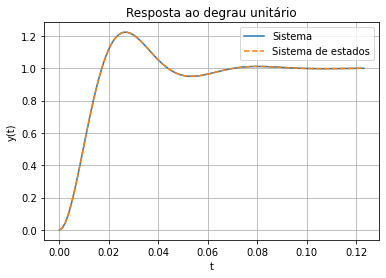

In [34]:
x, y = control.step_response(system)
x2, y2 = control.step_response(G)
plt.figure()
plt.plot(x, y, label='Sistema')
plt.plot(x2, y2, ls= '--', label='Sistema de estados')
plt.title("Resposta ao degrau unitário")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Verificando polos da planta
eigenvalues, eigenvectors = linalg.eig(A);
poles = eigenvalues
print(poles)

[-56.16830065+117.75321299j -56.16830065-117.75321299j]


In [36]:
Ts5 = NT *1e-3
Mp = len('Enzzo')*2/100

# Adotando 10 vezes como escolha, temos Ts = Ts5/10 = 19ms/10 = 1.9ms
Ts = Ts5/10
Fs = 1/Ts

zeta = 1.2 * math.sqrt(math.log(Mp)**2/(math.log(Mp)**2 + math.pi**2))
wn = 1.2*3/(zeta*(Ts5))
wd = wn*math.sqrt(1-(zeta**2))
ws = 2*math.pi/Ts

ws_wd_relation = ws/wd

# Polos dominantes desejados

s1 = -zeta*wn + 1j*wd
s2 = -zeta*wn - 1j*wd
s3 = -10*abs(s1);

print(f'zeta: {zeta}')
print(f'wd: {wd}')
print(f'wn: {wn}')
print(f'Ts: {Ts}')
print(f'Mp (%): {Mp*100}')
print(f'Fs: {Fs}')
print(f'\nPolos:\ns1 = {s1}\ns2 = {s2}\ns3 = {s3}')

zeta: 0.7093860405586769
wd: 149.0345406127992
wn: 211.45045352438495
Ts: 0.0024000000000000002
Mp (%): 10.0
Fs: 416.66666666666663

Polos:
s1 = (-149.99999999999997+149.0345406127992j)
s2 = (-149.99999999999997-149.0345406127992j)
s3 = -2114.5045352438497


In [37]:
# Não é possível realizarmos uma ação de controle em sistemas não lineares, por isso essa verificação

# Matriz de Controlabilidade
Mc = control.ctrb(A,B)
Mc

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc, 1e-12) 

if len(Mc) == rank_Mc:          
    print("O sistema é controlável")

O sistema é controlável


In [38]:
# Equação característica desejada
eq_des = np.poly([s1, s2, s3]);
eq_des

# Matrizes Expandidas
A_controle = np.block([[A, np.zeros([2,1])],[-C, 0]]);
B_controle = np.block([[B],[0]]);

# Matriz de ganhos do controlador K_chapeu = [k1 k2 -ki]
K_controle = control.acker(A_controle,B_controle,[s1, s2, s3])
K_controle

#Utilizando a formula do slide para termos o sistema expandido
K = np.block([K_controle[0,0], K_controle[0,1] ])
Ki = -K_controle[0,2]
AA = np.block([[A-B*K, B*Ki],[-C,0]])
BB = np.block([[0],[0],[1]])
CC = np.block([1, 0, 0])
DD = 0;

controlled_sys = control.ss(AA,BB,CC,DD);

In [39]:
print(K)

[38.8962891  75.14276136]


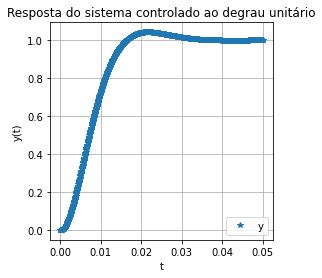

In [40]:
# resposta para entrada ao degrau do sistema controlado
tfinal = 0.05 
Y_ctrld, t_y_ctrld = control.matlab.step(controlled_sys,tfinal);

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(4,4)

ax1.plot(t_y_ctrld,Y_ctrld,'*')
ax1.set_title("Resposta do sistema controlado ao degrau unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")
ax1.legend(['y'],loc="lower right")
ax1.grid(True,'both')


In [41]:
# Sobressinal percentual
Mp = (max(Y_ctrld)-Y_ctrld[-1])/(Y_ctrld[-1]-Y_ctrld[0]);
print(f'Mp = {Mp*100}%')

# Tempo de acomodação para 5%

j = len(t_y_ctrld)-1;
delta = 0;
while (delta < tfinal):
    delta = abs((Y_ctrld[j]-Y_ctrld[-1])/Y_ctrld[-1]);
    ts = t_y_ctrld[j];
    j = j-1;
   
print(f'\nTs5% = {ts*1000}ms')

Mp = 4.294892046323269%

Ts5% = 14.360313315926891ms


In [42]:
#eq. recursivas

#t = t_y_ctrld


Fs = Fs*10
Ts = 1/Fs
tfinal = 0.05;

Kmax = int((tfinal/Ts)+1);

t =np.linspace(0, tfinal, Kmax);
r = np.ones(len(t));
r[0] = 0;

# declaração dos vetores
x1 = np.zeros(len(t));
x2 = np.zeros(len(t));
csi = np.zeros(len(t));

u = np.zeros(len(t));

x1_ponto = np.zeros(len(t));
x2_ponto = np.zeros(len(t));
csi_ponto = np.zeros(len(t));
y = np.zeros(len(t));

y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0

for j in range(0,len(t)):
    # Equações dos integradores
    x1[j] = Ts*x1_ponto[j-1] + x1[j-1];
    x2[j] = Ts*x2_ponto[j-1] + x2[j-1];    
    csi[j] = Ts*csi_ponto[j-1] + csi[j-1];

    # Equação da lei de controle
    u[j] = -(K[0]*x1[j] + K[1]*x2[j]) + Ki*csi[j];

    # Equação diferencial de estados:  Xponto=A*X+B*U
    x1_ponto[j] = A[0,0]*x1[j] + A[0,1]*x2[j] + B[0]*u[j];  
    x2_ponto[j] = A[1,0]*x1[j] + A[1,1]*x2[j] + B[1]*u[j]; 

    # Equação de Saída: Y=C*X+D*U
    y[j] = C[0,0]*x1[j]# + C[1]*x2[j]# + D*u[j];

    # Equação de erro
    csi_ponto[j] = r[j] - y[j];

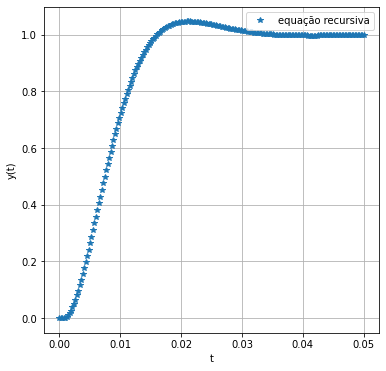

In [43]:
# comportamento da saída y                      
fig = plt.figure()
fig.set_size_inches(6,6)
plt.plot( t, y,'*')#t_y_ctrld, Y_ctrld,'-')#
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend(['equação recursiva'],loc="upper right")
plt.grid(True)
plt.show()

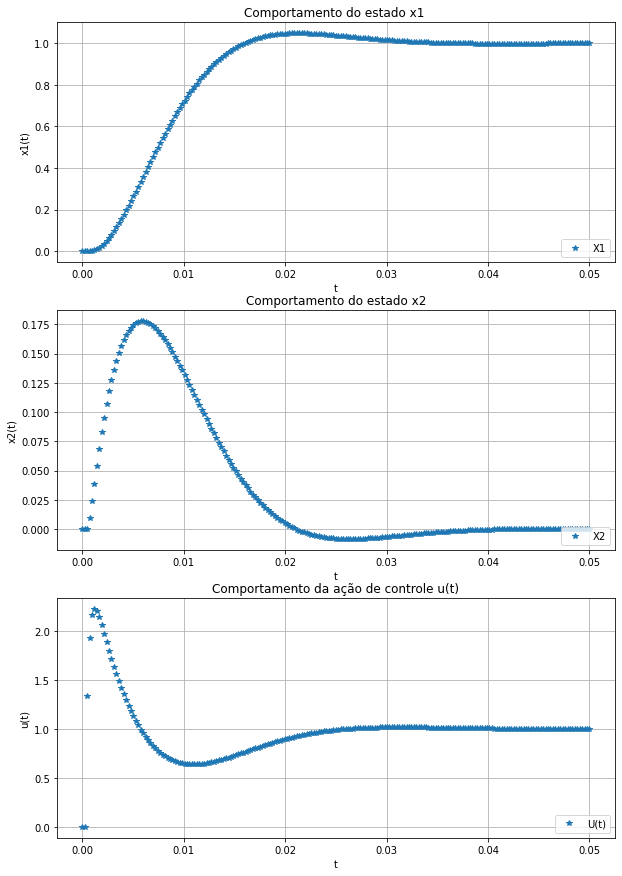

In [44]:
fig, ((ax1, ax2, ax3) ) = plt.subplots(3, 1)
fig.set_size_inches(10,15)

ax1.plot(t, x1,'*')
ax1.set_title("Comportamento do estado x1 ")
ax1.set_xlabel("t")
ax1.set_ylabel("x1(t)")
ax1.legend(['X1'],loc="lower right")
ax1.grid(True)

ax2.plot(t, x2,'*')
ax2.set_title("Comportamento do estado x2")
ax2.set_xlabel("t")
ax2.set_ylabel("x2(t)")
ax2.legend(['X2'],loc="lower right")
ax2.grid(True)

ax3.plot(t, u,'*')
ax3.set_title("Comportamento da ação de controle u(t)")
ax3.set_xlabel("t")
ax3.set_ylabel("u(t)")
ax3.legend(['U(t)'],loc="lower right")
ax3.grid(True)

#### Observador de ordem minima


In [45]:
# Matriz de observabilidade

N = control.obsv(A, C).T

# teste de observabilidade
rank_Mo = np.linalg.matrix_rank(N, 1e-12)   

if len(N) == rank_Mo:          
    print("O sistema é observável!")

O sistema é observável!


In [46]:
# Verificando polos da planta
eigenvalues, eigenvectors = linalg.eig(A);

# Polos escolhidos de forma que o observador tenha o dobro da velocidade do controlador
s1_obs = -5*abs(s1)
s2_obs = -5*abs(s2)

print(f'Polos do observador: \n\ns1: {s1_obs}\ns2:{s2_obs}')


Polos do observador: 

s1: -1057.2522676219248
s2:-1057.2522676219248


In [47]:
Abb = A[1,1]
Aab = A[0,1]
L = (s1_obs);
# Ganho 
Ke = control.acker(Abb,Aab,[L])
Ke = Ke[0,0]      # Transformando em escalar

Aaa = A[0,0];
Aba = A[1,0];
Ba = B[0,0];
Bb = B[1,0];

Achapeu = Abb-Ke*Aab;
Bchapeu = Achapeu*Ke+Aba-Ke*Aaa;
Fchapeu = Bb-Ke*Ba;

Cchapeu = np.matrix('0 ; 1');
Dchapeu = np.block([[1], [Ke]]);

print("L: " + str(L) + "\n")
print("Ke: " + str(Ke) + "\n")
print("Achapeu: " + str(Achapeu) + "\n")
print("Bchapeu: " + str(Bchapeu) + "\n")
print("Fchapeu: " + str(Fchapeu) + "\n")
print("Cchapeu: " + str(Cchapeu) + "\n")
print("Dchapeu: " + str(Dchapeu) + "\n")

# Matriz de Controlabilidade do sistema dual para ordem mínima
Mc = control.ctrb(Aab,Abb)

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc) # número de postos do sistema
print(rank_Mc)
print('A matriz é observável')


L: -1057.2522676219248

Ke: 1.7008481993665236

Achapeu: -1057.2522676219248

Bchapeu: -1828.8628705628857

Fchapeu: 30.637254901960787

Cchapeu: [[0]
 [1]]

Dchapeu: [[1.       ]
 [1.7008482]]

1
A matriz é observável


In [48]:
# simulação com equações recursivas
# definindo o intervalo de simulação e o vetor de entrada
T = 1/Fs;
tfinal = 0.2;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, int(Fs*tfinal))
u = np.ones(len(k));

# definindo os vetores
x1 = np.zeros(len(k));
x2 = np.zeros(len(k));
x1_ponto = np.zeros(len(k));
x2_ponto = np.zeros(len(k));
y = np.zeros(len(k));
eta1 = np.zeros(len(k));
eta1_ponto = np.zeros(len(k));
xtil1 = np.zeros(len(k));
xtil2 = np.zeros(len(k));

# condições iniciais (podem ser diferentes de zero)
x1[0] = 0;  #  para k = 0
x2[0] = 0;  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
eta1[0] = 0;  #  para k = 0
eta1_ponto[0] = Fchapeu*u[0];  #  para k = 0



for j in range(1,Kmax-1):
    # sistema original
        # Equações dos integradores
        x1[j]=T*x1_ponto[j-1]+x1[j-1];
        x2[j]=T*x2_ponto[j-1]+x2[j-1];    
        
        # Equação diferencial de estados:  Xponto=A*X+B*U
        x1_ponto[j]=A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
        x2_ponto[j]=A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 

        # Equação de Saída: Y=C*X+D*U
        y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];

    # observador de ordem mínima
        # Equações dos integradores do observador
        eta1[j]=T*eta1_ponto[j-1]+eta1[j-1];
    
        # Equação diferencial de estados do observador
        eta1_ponto[j]=Achapeu*eta1[j]+Bchapeu*y[j]+Fchapeu*u[j];
    
    # Transformação
        # equação de saída do observador de ordem mínima
        xtil1[j]=Cchapeu[0,0]*eta1[j]+Dchapeu[0]*y[j];
        xtil2[j]=Cchapeu[1,0]*eta1[j]+Dchapeu[1]*y[j];

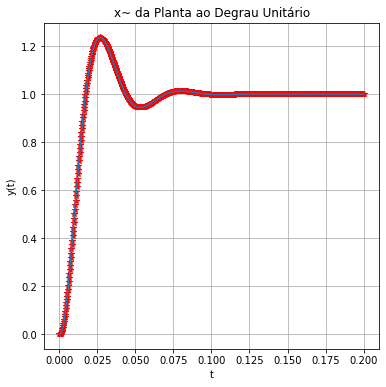

In [49]:
# resposta para entrada ao degrau
fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(6,6)

ax1.plot(k*T, xtil1, 'r*', k*T, x1)
ax1.set_title("x~ da Planta ao Degrau Unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")

ax1.grid(True,'both')

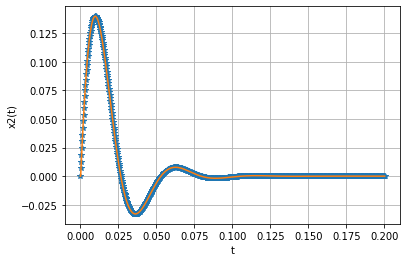

In [50]:
plt.figure()
plt.plot(k*T,xtil2, '*', k*T,x2)
plt.xlabel("t")
plt.ylabel("x2(t)")
plt.grid(True)
plt.show()

In [51]:
T = 1/Fs;
tfinal = 0.05;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, int(Fs*tfinal))


# definindo os vetores
r = np.ones(len(k));
u = np.zeros(len(k));
x1 = np.zeros(len(k));
x2 = np.zeros(len(k));
csi = np.zeros(len(k));
x1_ponto = np.zeros(len(k));
x2_ponto = np.zeros(len(k));
csi_ponto = np.zeros(len(k));
y = np.zeros(len(k));
eta1 = np.zeros(len(k));
eta1_ponto = np.zeros(len(k));
xtil1 = np.zeros(len(k));
xtil2 = np.zeros(len(k));

# condições iniciais (podem ser diferentes de zero)
x1[0] = 0;  #  para k = 0
x2[0] = 0;  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0
eta1[0] = 0;  #  para k = 0
eta1_ponto[0] = Fchapeu*u[0];  #  para k = 0
xtil1[1]=Cchapeu[0,0]*eta1[0]+Dchapeu[0]*y[0];
xtil2[1]=Cchapeu[1,0]*eta1[0]+Dchapeu[1]*y[0];
csi_ponto[0] = r[0] - y[0];



for j in range(1,Kmax-1):
    # sistema original
        # Equações dos integradores
        x1[j]=T*x1_ponto[j-1]+x1[j-1];
        x2[j]=T*x2_ponto[j-1]+x2[j-1];
        csi[j] = Ts*csi_ponto[j-1] + csi[j-1];
    
        # Equação da lei de controle + observador
        u[j] = -(K[0]*xtil1[j] + K[1]*xtil2[j]) + Ki*csi[j];
        
        # Equação diferencial de estados:  Xponto=A*X+B*U
        x1_ponto[j]=A[0,0]*x1[j]+A[0,1]*x2[j]+B[0]*u[j];  
        x2_ponto[j]=A[1,0]*x1[j]+A[1,1]*x2[j]+B[1]*u[j]; 
        
    # observador de ordem mínima
        # Equações dos integradores do observador
        eta1[j]=T*eta1_ponto[j-1]+eta1[j-1];
    
        
        # Equação de Saída: Y=C*X+D*U
        y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];
        
        # Equação diferencial de estados do observador
        eta1_ponto[j]=Achapeu*eta1[j]+Bchapeu*y[j]+Fchapeu*u[j];
        

        
        if j != (Kmax -2):
     # Transformação
        # equação de saída do observador de ordem mínima
            xtil1[j+1]=Cchapeu[0,0]*eta1[j]+Dchapeu[0]*y[j];
            xtil2[j+1]=Cchapeu[1,0]*eta1[j]+Dchapeu[1]*y[j];
        
        # Equação de erro
        csi_ponto[j] = r[j] - y[j];

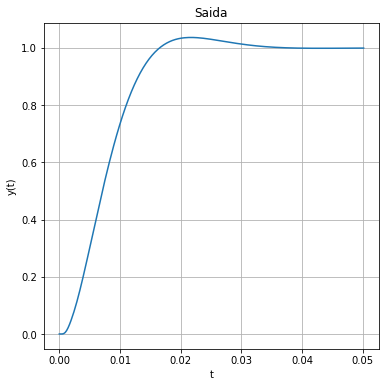

In [52]:
# resposta para entrada ao degrau
fig, ((ax1) ) = plt.subplots(1, 1)
fig.set_size_inches(6,6)

ax1.plot(k*T, y)
ax1.set_title("Saida")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")

ax1.grid(True,'both')

In [53]:
def relative_error(reference, value): 
    return abs((value-reference)/reference)*100;
    
def overshoot(signal):
    return relative_error(signal[-1], max(signal));

def settling_time(signal, t, percentage):
    delta = lambda x: abs((x[-1]-x)/x[-1]);
    absolute_difference = lambda x, idx, percentage: abs(x[idx]-x[-1]-percentage*x[-1]);
    
    idx = np.argwhere(delta(signal) > percentage)[-1][0];
    if absolute_difference(signal,idx,percentage) < absolute_difference(signal,idx+1,percentage):
        st = t[idx];
    else:
        st = t[idx+1];
    
    return st;

In [54]:
print(overshoot(y))

3.714933892672377


In [55]:
print(settling_time(y, k*T, 0.05))

0.014539130434782612
